# Aplicação de Métodos de Clustering na Análise do Diagrama de Hertzsprung-Russell
## Por Marcella Decembrino e Marcelo Lopes

### Tópicos
-
-
-

### Seleção do dataset
Neste trabalho foi utilizado um dataset com dados reais provenientes do HYG Stellar Database, um catálogo astronômico que reúne informações das bases Hipparcos, Yale Bright Star Catalog e Gliese.

Diversas informações sobre estrelas observadas são fornecidas, incluindo:
- Magnitude aparente (`mag`) e magnitude absoluta (`absmag`)
- Distância (`dist`, em parsecs)
- Índice de cor (`ci`, color index B-V)
- Temperatura (`temp`, em Kelvin)
- Luminosidade (`lum`, em múltiplos da luminosidade do Sol)
- Coordenadas espaciais (`x`, `y`, `z`) e coordenadas astronômicas (`ra`, `dec`)

Assim como as colunas `proper`, `con`, `var`, `var_min` e `var_max`, representando nomes, constelações e outros parâmetros fotométricos que não serão utilizados.

Visto que o conjunto de dados é proveniente de observações reais, a limpeza e análise de dados deverá considerar incertezas observacionais, ruídos instrumentais e metodológicos, assim como possíveis vieses provientes de limitações físicas dos métodos.

Considerando tais limitações, o objetivo é encontrar agrupamentos de estrelas que possuam características semelhantes, permitindo posteriormente comparações e o estudo da evolução estelar.

# Setup

Nesta seção, são carregadas bibliotecas para a obtenção, tratamento e processamento dos dados, visualização exploratória e aplicação de algoritmos de clustering.

## Obtenção, Tratamento e Processamento dos Dados

[...]

In [129]:
import pandas as pd
import numpy as np

## Visualização

[...]

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
from shapely.geometry import Polygon, MultiPolygon
import alphashape
import altair as alt

[...]

In [131]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import hdbscan

# Seleção do Dataset

[...]

In [132]:
# Dataset retirado de https://raw.githubusercontent.com/adamlamee/CODINGinK12/master/data/stars.csv
# Créditos em https://github.com/adamlamee/CODINGinK12/blob/master/notebooks/stars.ipynb

Primeiramente, serão definidos parâmetros identificando o nome do arquivo e as principais colunas a serem utilizadas para as análises, assim como colunas nunca utilizadas, que serão removidas.

In [133]:
plt.style.use("default")

dataset_file = "stars.csv"

col_color = "ci"
col_mag = "absmag"
col_temp = "temp"
col_lum = "lum"

cols_remover = ["proper", "con", "var", "var_min", "var_max"]

A seguir é realizado o carregamento do dataset em formato CSV por meio da biblioteca pandas. Após o carregamento, são removidas as colunas não utilizadas, e é feita uma inspeção para verificar as dimensões, tipos de dados e possíveis inconsistências na importação.

In [134]:
df = pd.read_csv(dataset_file)
df = df.drop(columns=cols_remover, errors="ignore")
print("Dimensões do dataset:", df.shape)
df.info()
df.head()

Dimensões do dataset: (119614, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119614 entries, 0 to 119613
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ra      119614 non-null  float64
 1   dec     119614 non-null  float64
 2   dist    119614 non-null  float64
 3   mag     119614 non-null  float64
 4   absmag  119614 non-null  float64
 5   ci      117732 non-null  float64
 6   temp    117732 non-null  float64
 7   x       119614 non-null  float64
 8   y       119614 non-null  float64
 9   z       119614 non-null  float64
 10  lum     119614 non-null  float64
dtypes: float64(11)
memory usage: 10.0 MB


,ra,dec,dist,mag,absmag,ci,temp,x,y,z,lum
0,0.000000,0.000000,0.0000,-26.70,4.850,0.656,5756.588113,0.000005,0.000000,0.000000,1.000000
1,14.495985,-62.679485,1.2959,11.01,15.447,1.807,3383.441193,-0.472264,-0.361451,-1.151219,0.000058
2,14.660765,-60.833976,1.3248,-0.01,4.379,0.710,5567.728737,-0.495203,-0.414084,-1.156625,1.543121
3,14.660346,-60.838300,1.3248,1.35,5.739,0.900,4996.415833,-0.495181,-0.413973,-1.156674,0.440961
4,17.963472,4.693388,1.8238,9.54,13.235,1.570,3691.168543,-0.017373,-1.816613,0.149123,0.000443


Antes de realizar limpeza e análise, os dados são visualizados por meio do diagrama Hertzsprung-Russell (HR).

Os objetivos desta etapa são:
- Identificar possíveis outliers
- Verificar consistência das variáveis

O diagrama relaciona índice de cor, uma variável que representa a diferença entre as intensidades de luz azul e vermelha observadas, com magnitude absoluta, relacionada à luminosidade intrínseca de uma estrela. 

É esperado que populações de estrelas semelhantes ocupem regiões específicas do plano do diagrama HR, gerando agrupamentos naturais.

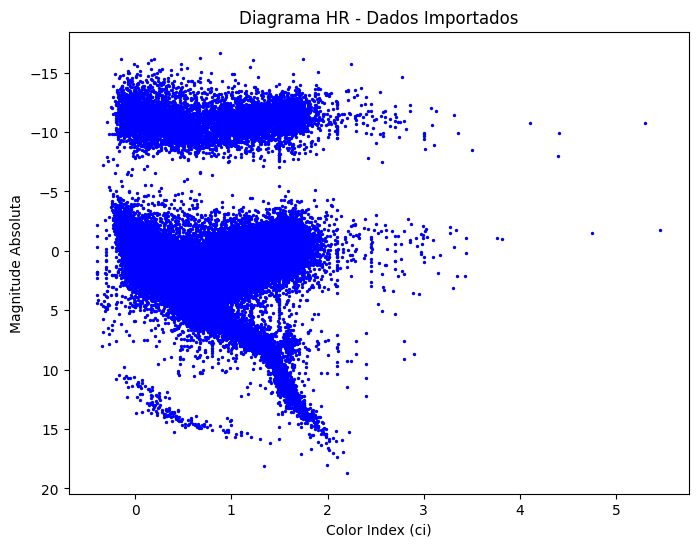

In [135]:
plt.figure(figsize=(8, 6))

plt.scatter(df[col_color], df[col_mag],
                c='blue',
                s=2)

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR - Dados Importados")
plt.show()

No diagrama gerado acima, é possível observar uma grande presença de estrelas na faixa de luminosidade absoluta entre -10 e -15. Embora existam estrelas com tal luminosidade, elas são extremamente raras na Via Láctea. 

A presença de uma grande quantidade de estrelas deste tipo sugere possíveis inconsistências nos dados, como vieses observacionais ou parâmetros pouco precisos gerando valores extremos para a magnitude absoluta por propagação de incertezas.

Para investigação, utiliza-se o método `.describe()` para analisar uma forma resumida das estatísticas do dataset.

In [136]:
df.describe()

,ra,dec,dist,mag,absmag,ci,temp,x,y,z,lum
count,119614.000000,119614.000000,119614.000000,119614.000000,119614.000000,117732.000000,117732.000000,119614.000000,119614.000000,119614.000000,1.196140e+05
mean,12.095243,-1.985101,8764.801178,8.429685,0.992129,0.711495,6182.806403,-234.845474,-39.569343,-231.897239,3.544691e+05
std,6.887589,40.965885,27879.567299,1.427732,4.351890,0.493207,2063.029405,15178.258403,17237.818362,18068.210978,3.333300e+06
min,0.000000,-89.782428,0.000000,-26.700000,-16.680000,-0.400000,1499.338347,-99950.391270,-99979.246190,-99964.982270,1.230000e-06
25%,6.217463,-36.420663,115.074800,7.650000,0.139000,0.348000,4551.904315,-89.020936,-91.173028,-107.538313,4.746790e+00
50%,12.127568,-1.639570,213.675200,8.460000,1.495000,0.616000,5905.594297,-1.044429,-1.241516,-3.410872,2.197860e+01
75%,18.116667,31.519006,390.625000,9.170000,3.159000,1.083000,7169.831570,86.267843,91.846196,94.974160,7.663021e+01
max,23.998594,89.569427,100000.000000,21.000000,19.629000,5.460000,21707.421710,99982.372690,99996.065510,99862.513670,4.092607e+08


O primeiro erro notável é em relação às distâncias. O valor máximo para elas está extremamante alto, e medidas astronômicas à tais distâncias podem ser extremamente imprecisas, por possíveis efeitos de nuvens de poeira, erros de fotometria, entre outros. 

É possível observar que o valor máximo para as distâncias é extremamente elevado. Medidas astronômicas para tais valores estão fortemente sujeitas a incertezas fotométricas, efeitos de absorção por poeira interestelar, além de limitações instrumentais e erros na medição de paralaxe.

Portanto, para a primeira limpeza, optou-se pela remoção de estrelas com distância acima de 5000 parsecs.

In [137]:
df = df[df["dist"] < 5000]

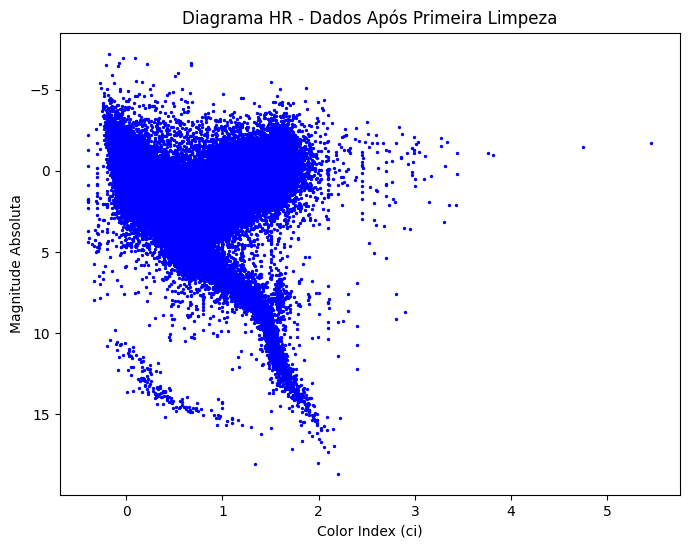

In [138]:
plt.figure(figsize=(8, 6))

plt.scatter(df[col_color], df[col_mag],
                c='blue',
                s=2)

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR - Dados Após Primeira Limpeza")
plt.show()

Após a primeira etapa, observa-se que o diagrama acima apresenta uma distribuição mais coerente com o esperado para populações estelares reais. A concentração de estrelas extremamente luminosas no diagrama foi reduzida de forma significativa somente utilizando o filtro de distâncias. Porém, ainda é possível observar certos valores extremos, especialmente em relação ao Color Index.

A seguir, são implementados os seguintes filtros, a fim de garantir a consistência física e estabilidade dos modelos de clustering a serem construídos posteriormente:
- Color Index: entre -0.5 e 2.5
- Magnitude Absoluta: entre -15 e 20
- Temperatura: entre 2000 K e 50000 K
- Luminosidade: acima de 0 

Os intervalos acima abrangem praticamente todas as estrelas conhecidas, excluindo somente valores inconsistentes e resultantes de erros experimentais.

Além disso, valores extremos como $-\infty$ e $\infty$ serão substituídos por `NaN`, e entradas com valores `NaN` nas principais colunas serão removidas do dataframe.

In [139]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[col_color, col_mag, col_temp, col_lum])

df = df[df[col_color].between(-0.5, 2.5)]
df = df[df[col_mag].between(-15, 20)]
df = df[df[col_temp].between(2000, 50000)]
df = df[df[col_lum] > 0]

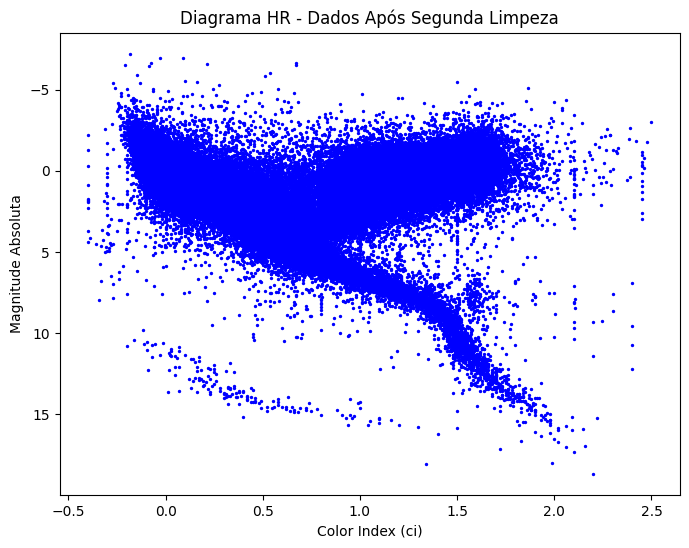

In [140]:
plt.figure(figsize=(8, 6))

plt.scatter(df[col_color], df[col_mag],
                c='blue',
                s=2)

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR - Dados Após Segunda Limpeza")
plt.show()

Após a segunda etapa de limpeza, observa-se que o diagrama possui uma distribuição compatível com a estrutura conhecida para populações estelares. 

Em seguida, calcula-se um raio estimado para cada estrela, com base na Lei de Stefan-Boltzmann ($L=4\pi R^2 T^4$). A partir disso, é possível derivar uma fórmula para isolar o raio em unidades solares. Considerando $T_\odot=5772 K$, tem-se que:

$$\frac{L}{L_\odot}=\left(\frac{R}{R_\odot}\right)^2\left(\frac{T}{T_\odot}\right)^4$$

$$\frac{R}{R_\odot}=\sqrt{\frac{L}{(T/T_\odot)^4}}$$

Além do raio estimado, será definida uma variável indicando as estrelas com características compatíveis com a categoria de "anãs brancas" (quentes e pouco luminosas). 

Essas estrelas foram selecionadas como as que possuem magnitude absoluta acima de $10$ e índice de cor abaixo de $0.5$.

In [141]:
Tsun = 5772
df["radius_est"] = np.sqrt(df[col_lum] / ((df[col_temp] / Tsun) ** 4))
col_raio = "radius_est"

# Identificação de anãs brancas
df["white_dwarf_flag"] = (
    (df[col_mag] > 10) &
    (df[col_color] < 0.5)
)

Antes das análises de clusterização, seleciona-se uma amostra do dataframe previamente filtrado, considerando 50.000 estrelas. Essa etapa reduz o custo computacional dos algoritmos, mas mantém a representatividade estatística da distribuição, além de garantir a reprodutibilidade por meio do estado aleatório `random_state=56`

In [142]:
df = df.sample(50000, random_state=56)

Abaixo, são determinadas as cores e classes espectrais de cada estrela, com base em faixas de temperatura.

Além disso, adiciona-se uma coluna com o logaritmo da temperatura na base 10, garantindo consistência com o diagrama HR clássico, além de reduzir assimetrias na distribuição, auxiliando na aplicação dos algoritmos de clustering.

In [143]:
classes = [0, 3700, 5200, 6000, 7500, 10000, 30000, np.inf]
labels = ["M", "K", "G", "F", "A", "B", "O"]

cores_espectrais = {
    "O": "#4f6cff",
    "B": "#7ea8ff",
    "A": "#dbe9ff",
    "F": "#fff7d6",
    "G": "#ffe86b",
    "K": "#ffb347",
    "M": "#ff5c5c"
}
df["classe_espectral"] = pd.cut(df[col_temp], bins=classes, labels=labels, right=False)

df["log_temp"] = np.log10(df["temp"])
col_temp_log = "log_temp"

O diagrama HR da amostra, apresentado abaixo, demonstra a conservação da estrutura esperada para populações estelares.

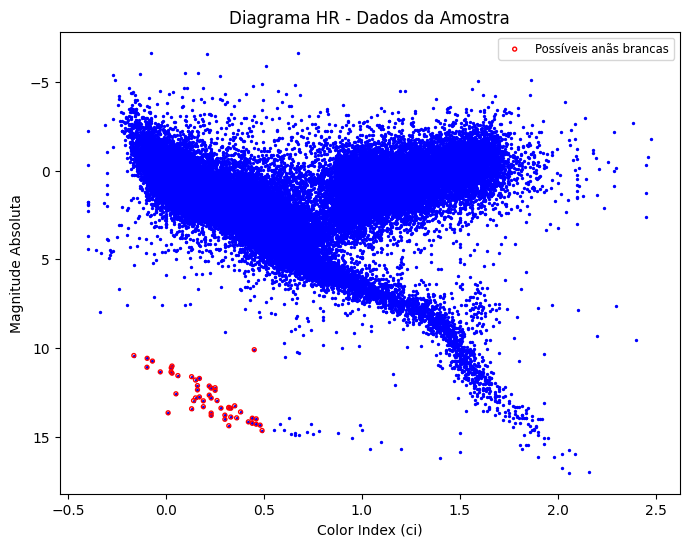

In [144]:
plt.figure(figsize=(8, 6))

plt.scatter(df[col_color], df[col_mag],
                c='blue',
                s=2)

wd = df[df["white_dwarf_flag"]]
plt.scatter(wd[col_color], wd[col_mag],
            edgecolors="red",
            facecolors="none",
            s=8,
            label="Possíveis anãs brancas")

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR - Dados da Amostra")
plt.legend(markerscale=1, fontsize="small", loc="best")
plt.show()


# Clustering

## Configurações Iniciais

In [15]:
variaveis = df[[col_mag, col_temp_log]]
scaler = StandardScaler()
variaveis_s = scaler.fit_transform(variaveis)

In [16]:
def plot_cluster (dados_x, dados_y, clusters, metodo):

    plt.style.use("default")
    
    plt.figure(figsize=(8, 6))

    # Plot dos dados originais coloridos com base no cluster a que pertencem
    for c in np.unique(clusters):
        mask = clusters == c
        plt.scatter(dados_x[mask], dados_y[mask],
                    s=2, alpha=1,
                    label=f"Cluster {c}")

    # Ajustes gerais do plot

    plt.gca().invert_yaxis() # Inverter eixo y
    plt.gca().invert_xaxis() # Inverter eixo x

    plt.xscale("log") # Eixo x na escala log para melhor visualização

    plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
    plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

    plt.title(f"Diagrama HR com Clustering por {metodo}")
    plt.legend(markerscale=1, fontsize="small", loc="best")

    plt.show()

    return

In [17]:
def plot_cluster_alt (cluster, metodo):

    alt.data_transformers.disable_max_rows()

    grafico = alt.Chart(df).mark_circle().encode( # formato circular
        
    # Definição de escala log no eixo x e limitação da faixa de valores a serem mostrados
    alt.X("temp:Q", scale=alt.Scale(reverse=True, type="log", domain=[2500, 22000]), title="Temperatura (K)", axis=alt.Axis(grid=False)),

    # Eixo y sem mostrar o 0 e limitação da faixa de valores a serem mostrados 
    alt.Y("absmag:Q", scale=alt.Scale(reverse=True), title="Magnitude Absoluta", axis=alt.Axis(grid=False)),

    # A cor da bolha depende do continente ao qual o país a que a bolha se refere está inserido
    color = alt.Color(f"{cluster}:Q", title=f"{cluster}", scale = alt.Scale(scheme="category20b")) # Define-se, também, uma escala de cor
    
    ).properties(width=700, height=600, title=f"Diagrama HR com {metodo}").interactive()

    return grafico

## K-Means

In [18]:
def encontrar_k (dados, k_max): # k_max: maior k a ser incluído na visualização

    plt.style.use("default")

    k_elbow = [] # valores de k para cada valor de inércia correspondente
    k_silhouettes = [] # valores de k para cada silhouette score correspondente
    inertias = [] # valores encontrados para a inércia
    silhouettes = [] # valores encontrados para os silhouette scores

    # Gera silhouette scores e valores de inércia para k de 1 (inércia) ou 2 (silhouette) a k_max
    for k in range (1, k_max + 1): 
        kmeans = KMeans(n_clusters=k, random_state=56) # inicialização da instância de KMeans
        kmeans.fit(dados) # aplicação do processo ao conjunto de dados
        
        k_elbow.append(k) # armazenamento do valor de k atual
        inertias.append(kmeans.inertia_) # cálculo e armazenamento do valor de inércia para o k atual

        if k != 1: # Silhouette Scores só são válidos para k > 1
            score = silhouette_score(dados, kmeans.labels_) # cálculo do silhouette score
            silhouettes.append(score) # armazenamento do silhouette score
            k_silhouettes.append(k) # armazenamento do valor de k atual
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) # criação da figura e dos dois subplots

    # Gráfico do elbow method
    axs[0].plot(k_elbow, inertias, marker="o", linestyle="-")
    axs[0].set_title("Elbow Method")
    axs[0].set_ylabel("Inertia")
    axs[0].set_xlabel("k")

    # Gráfico de silhouette score
    axs[1].plot(k_silhouettes, silhouettes, marker="o", linestyle="-")
    axs[1].set_title("Silhouette Score")
    axs[1].set_ylabel("Score")
    axs[1].set_xlabel("k")

    plt.tight_layout() # reajuste dos subplots para melhor organização dos gráficos
    plt.show() # exibição do gráfico

    return

In [19]:
def plot_k_means (dados_x, dados_y, clusters, kmeans, scaler):
    
    plt.style.use("dark_background")

    # Obtenção dos centroides na escala original
    centroides_iniciais = kmeans.cluster_centers_ # centroides na escala padronizada
    centroides = scaler.inverse_transform(centroides_iniciais) # centroides na escala original

    # Plot dos dados originais coloridos com base no cluster a que pertencem
    cores = cm.get_cmap("tab10", kmeans.n_clusters)
    
    for c in np.unique(clusters):
        mask = clusters == c
        plt.scatter(dados_x[mask], dados_y[mask],
                    s=2,
                    alpha=0.3,
                    color=cores(c),
                    label=f"Cluster {c}")

        # centróide do cluster c
        plt.scatter(centroides[c,1], centroides[c,0],
                    marker="X",
                    s=120,
                    color=cores(c),
                    edgecolor="black")

    # Ajustes gerais do plot

    plt.gca().invert_yaxis() # Inverter eixo y
    plt.gca().invert_xaxis() # Inverter eixo x

    plt.xscale("log") # Eixo x na escala log para melhor visualização

    plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
    plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

    plt.title("Diagrama HR com Clusterização por K-Means")
    plt.legend(markerscale=1, fontsize="small", loc="best")

    plt.show()

    return

In [20]:
def visualizar_k (dados_s, dados_x, dados_y, k_min, k_max):

    divisoes = [] # Lista que armazena as classificações para diferentes valores de k

    for k in range(k_min, k_max + 1): # Clustering para k de k_min a k_max

        kmeans = KMeans(n_clusters=k, random_state=42) # criação da instância de KMeans
        kmeans.fit(dados_s) # aplicação do K-Means aos dados
        divisao = kmeans.labels_ # obtenção das classificações dos dados
        divisoes.append(divisao) # armazenamento das classificações
    
    # Plot da figura com os diferentes gráficos distribuídos horizontalmente e com tamanhos iguais

    plt.style.use("dark_background")
    
    fig, axs = plt.subplots(nrows=1, ncols=k_max - k_min + 1, figsize=(5*k_max, 5))

    for i, ax in enumerate(fig.axes, start=1):

        # Plot individual dos gráficos para cada valor de k
        ax.scatter(x=dados_x, y=dados_y, c=divisoes[i - 1], s=2)
        ax.set_title(f"Clustering k = {k_min - 1 + i}")
        ax.set_xscale("log")
        ax.set_xlabel("Temperatura (K)")
        ax.set_ylabel("Magnitude Absoluta")

        ax.invert_xaxis()
        ax.invert_yaxis()


    plt.show()
        
    return

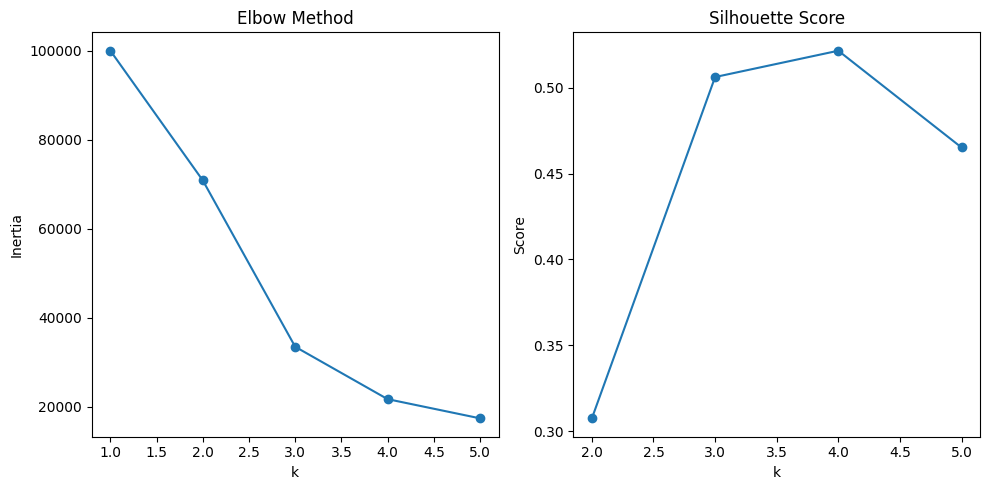

In [21]:
encontrar_k(variaveis_s, 5)

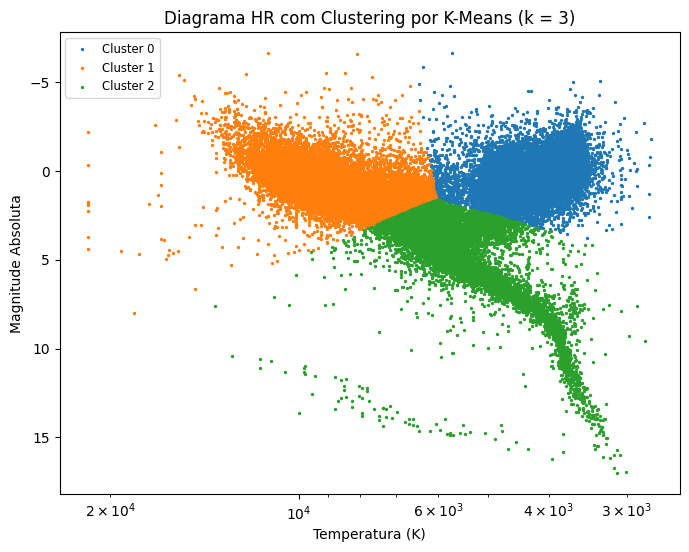

In [22]:
kmeans_3 = KMeans(n_clusters=3, random_state=50) # geração da instância de KMeans referente a k = 3
kmeans_3.fit(variaveis_s) # aplicação da instância aos dados padronizados

plot_cluster (df[col_temp], df[col_mag], kmeans_3.labels_, "K-Means (k = 3)")

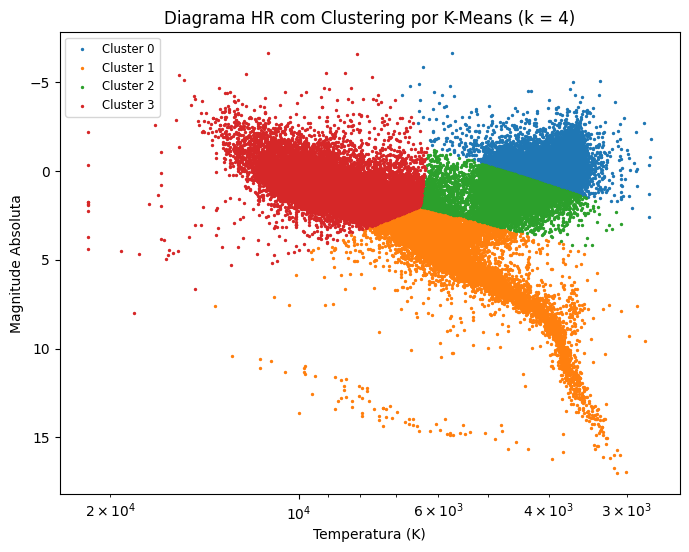

In [23]:
kmeans_4 = KMeans(n_clusters=4, random_state=50) # geração da instância de KMeans referente a k = 4
kmeans_4.fit(variaveis_s) # aplicação da instância aos dados padronizados

plot_cluster (df[col_temp], df[col_mag], kmeans_4.labels_, "K-Means (k = 4)")

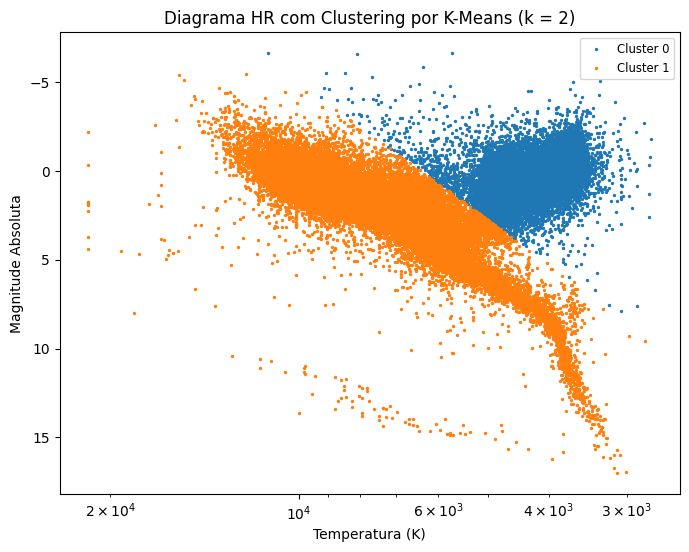

In [24]:
kmeans_2 = KMeans(n_clusters=2, random_state=50) # geração da instância de KMeans referente a k = 4
kmeans_2.fit(variaveis_s) # aplicação da instância aos dados padronizados

plot_cluster (df[col_temp], df[col_mag], kmeans_2.labels_, "K-Means (k = 2)")

## DBSCAN

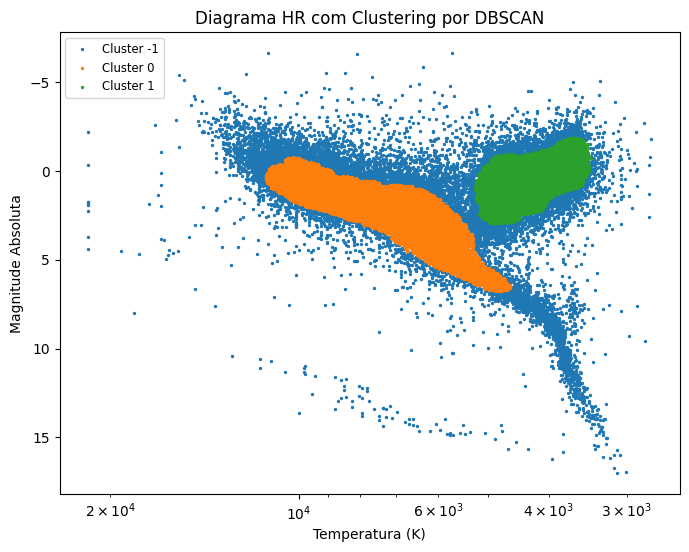

In [25]:
dbscan_modelo = DBSCAN(eps=0.1, min_samples=133).fit(variaveis_s) # criação do modelo para cada combinação
dbscan_labels = dbscan_modelo.labels_ # obtenção da classificação dos dados para cada modelo

df["dbscan"] = dbscan_labels # armazenamento das classificações

plot_cluster (df[col_temp], df[col_mag], df["dbscan"], "DBSCAN")

In [ ]:
plot_cluster_alt ("dbscan", "DBSCAN")

## GMM

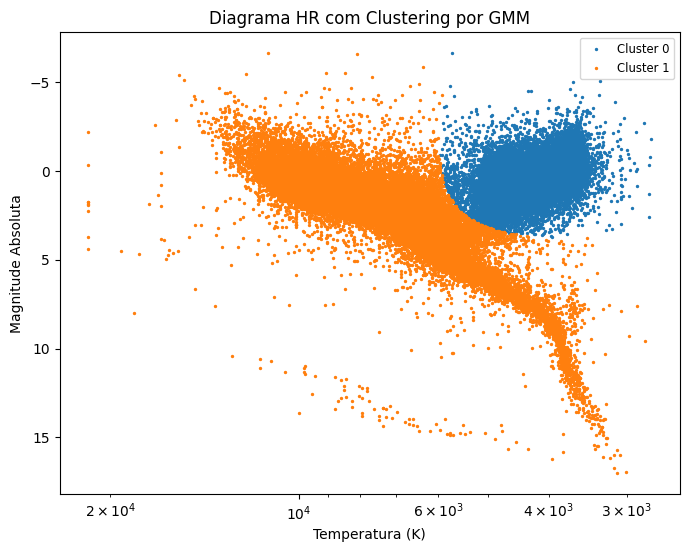

In [27]:
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=50)
gmm_labels_2 = gmm.fit_predict(variaveis_s)

plot_cluster (df[col_temp], df[col_mag], gmm_labels_2, "GMM")


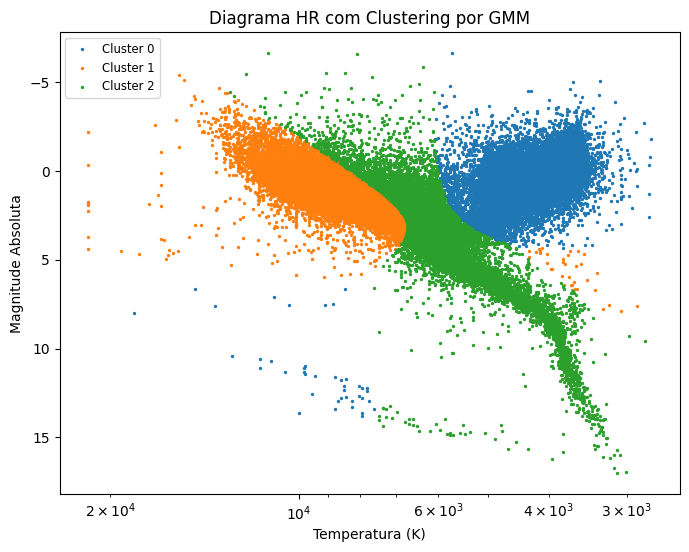

In [28]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=50)
gmm_labels_3 = gmm.fit_predict(variaveis_s)

plot_cluster (df[col_temp], df[col_mag], gmm_labels_3, "GMM")

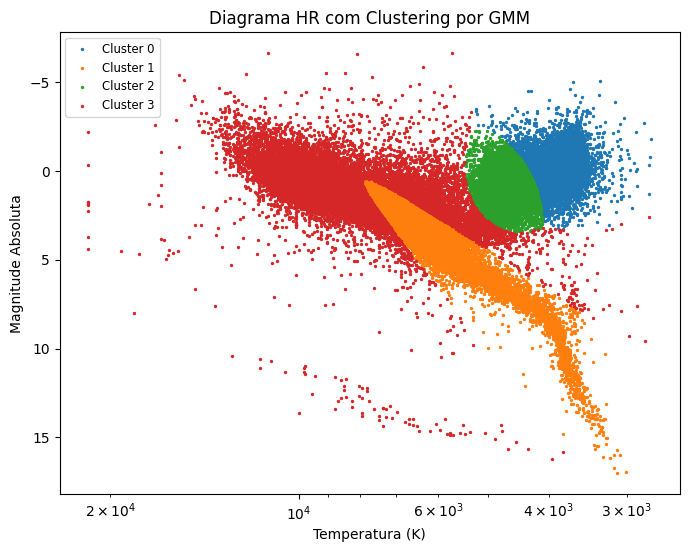

In [29]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=50)
gmm_labels_4 = gmm.fit_predict(variaveis_s)

plot_cluster (df[col_temp], df[col_mag], gmm_labels_4, "GMM")

## HDBSCAN

In [30]:
min_cluster_size = 100

cluster_hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
df["hdbscan"] = cluster_hdbscan.fit_predict(variaveis_s)

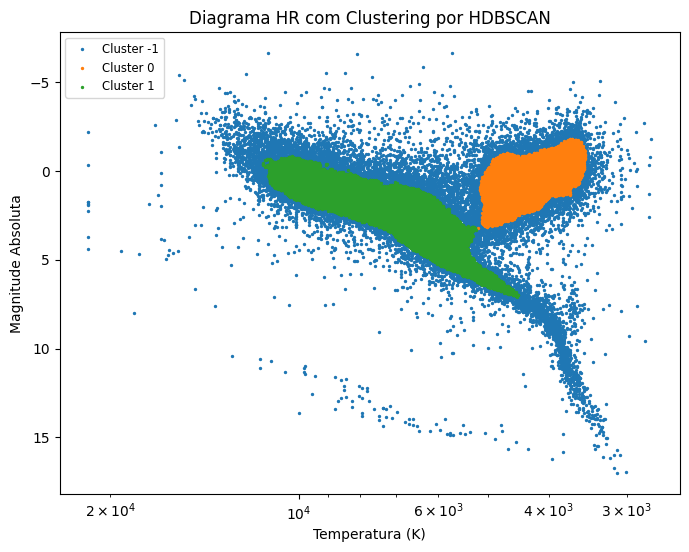

In [31]:
plot_cluster (df[col_temp], df[col_mag], df["hdbscan"], "HDBSCAN")


# Conclusões

# Análise de Dados - Diagrama HR

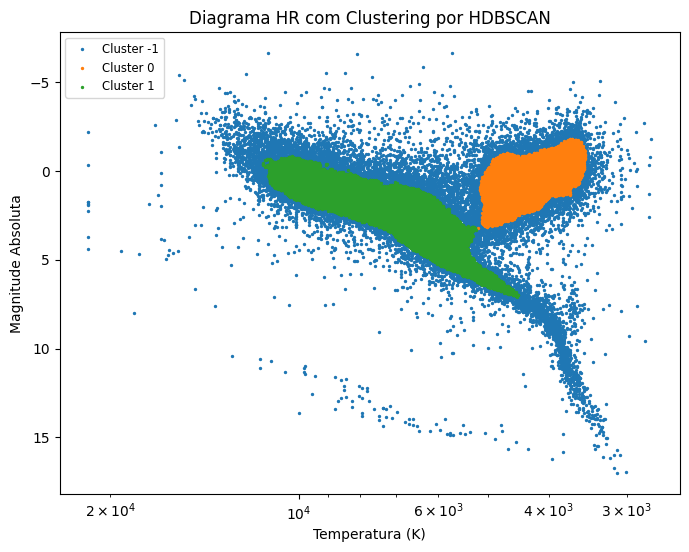

In [32]:
plot_cluster (df[col_temp], df[col_mag], df["hdbscan"], "HDBSCAN")

In [33]:
df["clusters"] = df["hdbscan"]
df.loc[df["white_dwarf_flag"] == True, "clusters"] = 2

df_sem_ruido = df[df["clusters"] != -1].copy()

In [34]:
df_sem_ruido["clusters"].unique()

array([1, 0, 2])

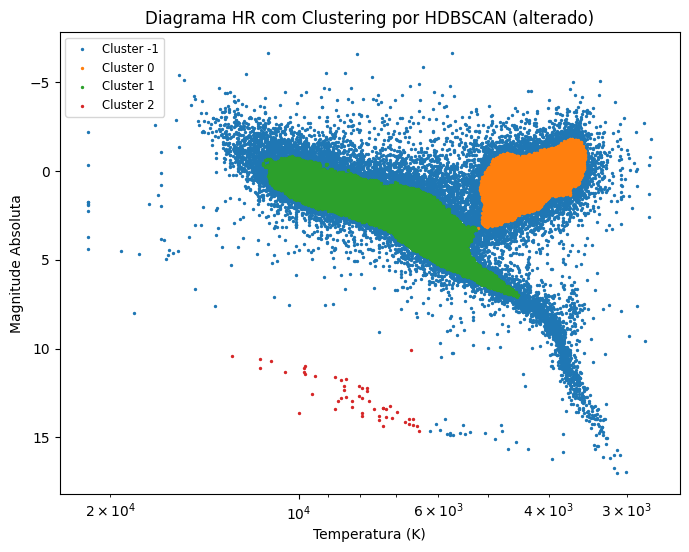

In [35]:
plot_cluster (df[col_temp], df[col_mag], df["clusters"], "HDBSCAN (alterado)")

## Cores

In [36]:
ordem_espectral = {
    "O": 0,
    "B": 1,
    "A": 2,
    "F": 3,
    "G": 4,
    "K": 5,
    "M": 6
}

df_sem_ruido["ordem_espectral"] = df_sem_ruido["classe_espectral"].map(ordem_espectral)

In [102]:
labels = ["M", "K", "G", "F", "A", "B", "O"]

hist_classe_spec = alt.Chart(df_sem_ruido).transform_joinaggregate(
    total='count()',
    groupby=['clusters']
).transform_calculate(
    percent='1 / datum.total'
).mark_bar(size=60).encode(
    x=alt.X(
        "clusters:N",
        title="Clusters",
        axis=alt.Axis(labelAngle=0),
        scale=alt.Scale(paddingInner=0.6)
    ),

    y=alt.Y(
        "sum(percent):Q",
        stack="zero",
        title="Frequência (%)",
        axis=alt.Axis(format="%")
    ),

    order=alt.Order(
    "ordem_espectral:Q",
    sort="descending"
),

color=alt.Color(
    "classe_espectral:N",
    title="Classes Espectrais",
    scale=alt.Scale(
        domain=["O","B","A","F","G","K","M"],
        range=[cores_espectrais[c] for c in ["O","B","A","F","G","K","M"]]
    )
    ),
    tooltip=[
        alt.Tooltip("classe_espectral:N", title="Classe Espectral"),
        alt.Tooltip("clusters:Q", title="Cluster"),
        alt.Tooltip("sum(percent):Q", format=".2%", title="Porcentagem"),
        alt.Tooltip("count():Q", title="Frequência")
    ]
).properties(
    height=450,
    width=500,
    title="Histograma de Classes Espectrais por Clusters"
).interactive()

In [ ]:
hist_classe_spec

Obs: teoricamente anãs brancas têm uma classificação separada (D), mas o diagrama acima serve para comparar com as cores das classes espectrais padrão, indicando faixa de temperatura e cor.

In [ ]:
labels = ["M", "K", "G", "F", "A", "B", "O"]

hist = alt.Chart(df_sem_ruido).transform_joinaggregate(
    total='count()',
    groupby=['clusters']
).transform_calculate(
    percent='1 / datum.total'
).mark_bar(size=60).encode(
    x=alt.X(
        "clusters:N",
        title="Clusters",
        axis=alt.Axis(labelAngle=0),
        scale=alt.Scale(paddingInner=0.6)
    ),

    y=alt.Y(
        "sum(percent):Q",
        stack="zero",
        title="Frequência (%)",
        axis=alt.Axis(format="%")
    ),

    order=alt.Order(
    "ordem_espectral:Q",
    sort="descending"
),

color=alt.Color(
    "classe_espectral:N",
    title="Classes Espectrais",
    scale=alt.Scale(
        domain=["O","B","A","F","G","K","M"],
        range=[cores_espectrais[c] for c in ["O","B","A","F","G","K","M"]]
    )
    ),
    tooltip=[
        alt.Tooltip("classe_espectral:N", title="Classe Espectral"),
        alt.Tooltip("clusters:Q", title="Cluster"),
        alt.Tooltip("sum(percent):Q", format=".2%", title="Porcentagem"),
        alt.Tooltip("count():Q", title="Frequência")
    ]
).properties(
    height=450,
    width=500,
    title="Histograma de Classes Espectrais por Clusters"
).interactive()

hist

In [93]:
def boxplot_por_cluster(dados, var_y, nome_y, titulo, inv_y=False, log_y=False):
    lista = ["M", "G", "A"]
    cores = [cores_espectrais[classe] for classe in lista]

    if log_y:
        escala_y = alt.Scale(type="log", reverse=inv_y)
    else:
        escala_y = alt.Scale(reverse=inv_y)

    box = alt.Chart(dados).mark_boxplot(
        size=60
    ).encode(
        x=alt.X(
            "clusters:N",
            title="Clusters",
            axis=alt.Axis(labelAngle=0)
        ),
        y=alt.Y(
            f"{var_y}:Q",
            title=nome_y,
            scale=escala_y
        ),
        color=alt.Color(
            "clusters:O",
            scale=alt.Scale(range=cores),
            legend=None
        ),
        tooltip=[
            alt.Tooltip("clusters:N", title="Cluster"),
            alt.Tooltip(f"{var_y}:Q", title=nome_y)
        ]
    ).properties(
        width=500,
        height=450,
        title=f"{titulo}"
    )
    return box

In [99]:
boxplot_temp = boxplot_por_cluster(df_sem_ruido, "temp", "Temperatura (K)", "Distribuição de Temperaturas por Cluster")
boxplot_absmag = boxplot_por_cluster(df_sem_ruido, "absmag", "Magnitude Absoluta", "Distribuição de Magnitudes Absolutas por Cluster", inv_y=True)
boxplot_dist = boxplot_por_cluster(df_sem_ruido, "dist", "Distância (ly)", "Distribuição de Distâncias por Cluster")
boxplot_raio = boxplot_por_cluster(df_sem_ruido, "radius_est", "Raio (x Raio Solar)", "Distribuição de Raios por Cluster", log_y=False)
boxplot_raio_log = boxplot_por_cluster(df_sem_ruido, "radius_est", "Raio (x Raio Solar)", "Distribuição de Raios por Cluster", log_y=True)

In [ ]:
boxplot_temp

In [ ]:
boxplot_absmag

In [ ]:
boxplot_raio

In [ ]:
boxplot_raio_log

No boxplot acima, é possível observar que as estrelas do tipo 0 possuem raios muito maiores que as estrelas de outros clusters, enquanto estrelas do tipo 2 possuem raios muito menores.

In [ ]:
boxplot_dist

No boxplot acima, é possível observar um viés importante para explicar a baixa quantidade de anãs brancas no dataset. Além da relativa raridade, não foram identificadas estrelas deste tipo a partir de determinada distância, o que pode ser explicado também considerando a baixa luminosidade e o raio pequeno, que as torna difíceis de identificar.

# Construção do Gráfico

In [38]:
dfp = df.sample(10000, random_state=56)

## DBSCAN

### Gráfico 01 - Tamanho dependente do Raio

In [39]:
r = dfp[col_raio]

# corta outliers
r_clip = r.clip(r.quantile(0.05), r.quantile(0.95))

# normaliza tamanho
s_min, s_max = 5, 60
s = s_min + (r_clip - r_clip.min())/(r_clip.max() - r_clip.min()) * (s_max - s_min)

In [40]:
cores = {
    -1: "gray",     # ruído
     0: "blue",
     1: "red",
}

c = dfp["dbscan"].map(cores)

C:\Users\Marcelo\AppData\Local\Temp\ipykernel_17220\3296475971.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


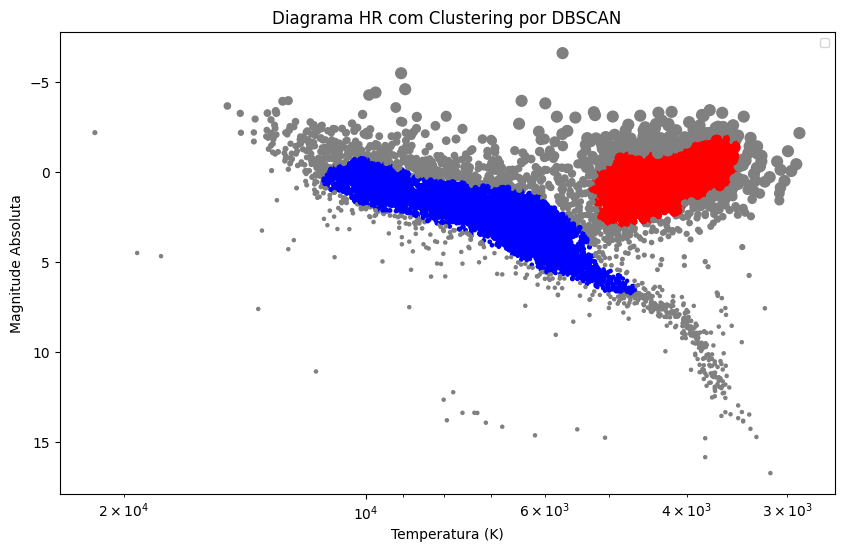

In [41]:
plt.style.use("default")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=c)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

### Gráfico 02 - Adição de Contornos

In [42]:
def desenhar_elipse(x, y, ax, n_std=3.5, **kwargs):
    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)

    # autovalores e autovetores
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # ângulo da elipse
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # largura e altura (raiz dos autovalores)
    width, height = 2 * n_std * np.sqrt(vals)

    ellipse = Ellipse((mean_x, mean_y),
                      width=width, height=height,
                      angle=theta,
                      fill=False,
                      **kwargs)

    ax.add_patch(ellipse)

C:\Users\Marcelo\AppData\Local\Temp\ipykernel_17220\1939811831.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


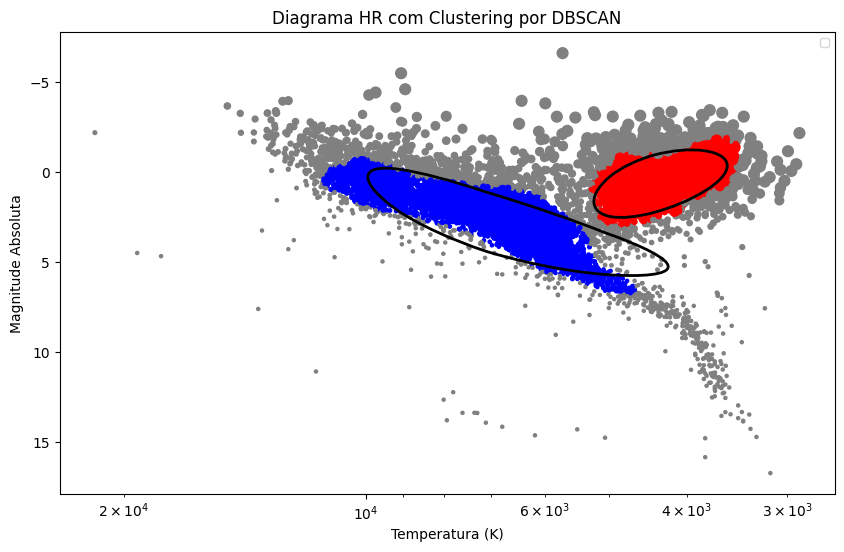

In [43]:
plt.style.use("default")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=c)

for cl in sorted(dfp["dbscan"].unique()):
    if cl == -1:
        continue  # ignora ruído

    subset = dfp[dfp["dbscan"] == cl]

    desenhar_elipse(subset[col_temp], subset[col_mag], ax,
                    n_std=2.0, edgecolor="black", linewidth=2)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

C:\Users\Marcelo\AppData\Local\Temp\ipykernel_17220\3011940652.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


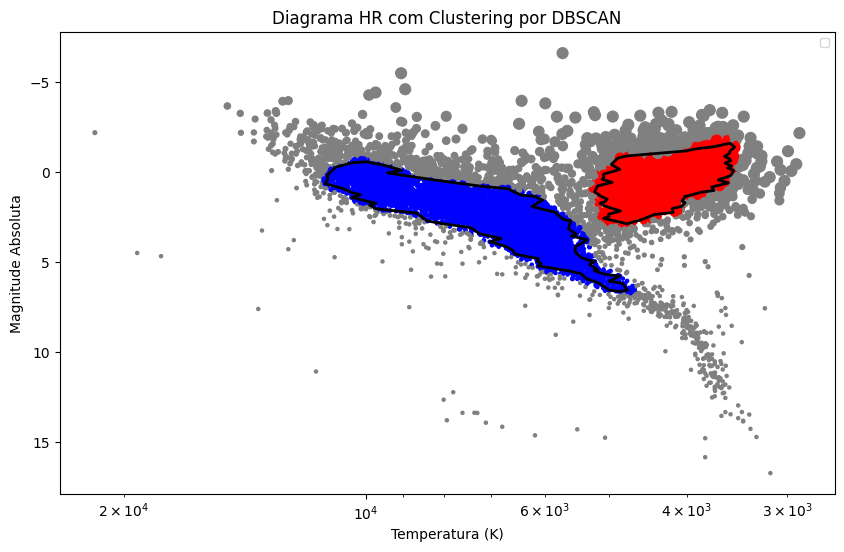

In [44]:
plt.style.use("default")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=c)

for cl in sorted(dfp["dbscan"].unique()):
    if cl == -1:
        continue

    subset = dfp[dfp["dbscan"] == cl]

    if len(subset) > 600:
        subset = subset.sample(600, random_state=0)

    x = np.log10(subset[col_temp].values)
    y = subset[col_mag].values

    pontos = list(zip(x, y))

    alpha = 1.0
    shape = alphashape.alphashape(pontos, alpha)

    if isinstance(shape, Polygon):
        xs, ys = shape.exterior.xy
        ax.plot(10**np.array(xs), ys, color="black", linewidth=2)

    elif isinstance(shape, MultiPolygon):
        for geom in shape.geoms:
            xs, ys = geom.exterior.xy
            ax.plot(10**np.array(xs), ys, color="black", linewidth=2)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

### Gráfico 03 - Classes Espectrais

In [45]:
cores_espectrais = {
    "O": "#4f6cff",
    "B": "#7ea8ff",
    "A": "#dbe9ff",   # branco azulado mais visível
    "F": "#fff7d6",   # branco levemente amarelado
    "G": "#ffe86b",
    "K": "#ffb347",
    "M": "#ff5c5c"
}

dfp["cor_espectral"] = dfp["classe_espectral"].map(cores_espectrais)

C:\Users\Marcelo\AppData\Local\Temp\ipykernel_17220\3930702210.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


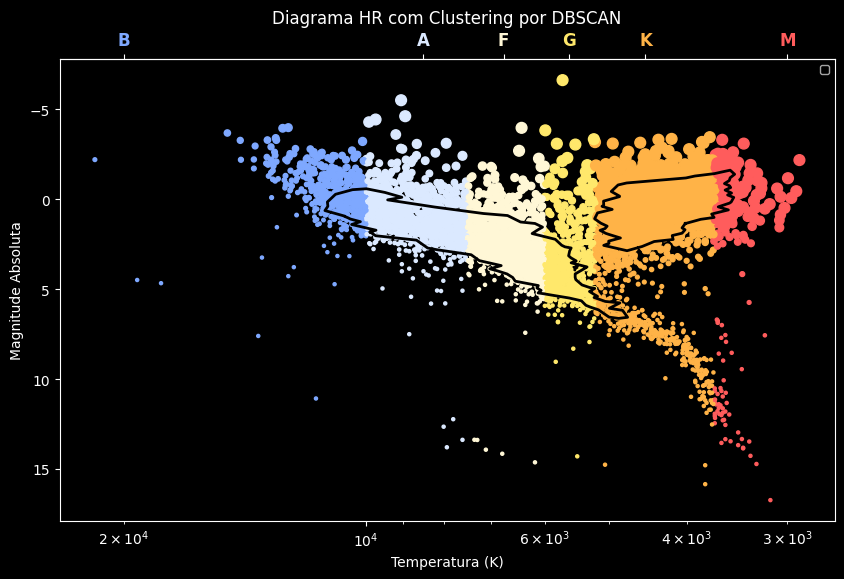

In [46]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

for cl in sorted(dfp["dbscan"].unique()):
    if cl == -1:
        continue

    subset = dfp[dfp["dbscan"] == cl]

    if len(subset) > 600:
        subset = subset.sample(600, random_state=0)

    x = np.log10(subset[col_temp].values)
    y = subset[col_mag].values

    pontos = list(zip(x, y))

    alpha = 1.0
    shape = alphashape.alphashape(pontos, alpha)

    if isinstance(shape, Polygon):
        xs, ys = shape.exterior.xy
        ax.plot(10**np.array(xs), ys, color="black", linewidth=2)

    elif isinstance(shape, MultiPolygon):
        for geom in shape.geoms:
            xs, ys = geom.exterior.xy
            ax.plot(10**np.array(xs), ys, color="black", linewidth=2)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

### Gráfico 04 - Retas com Raios

C:\Users\Marcelo\AppData\Local\Temp\ipykernel_17220\3414466779.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


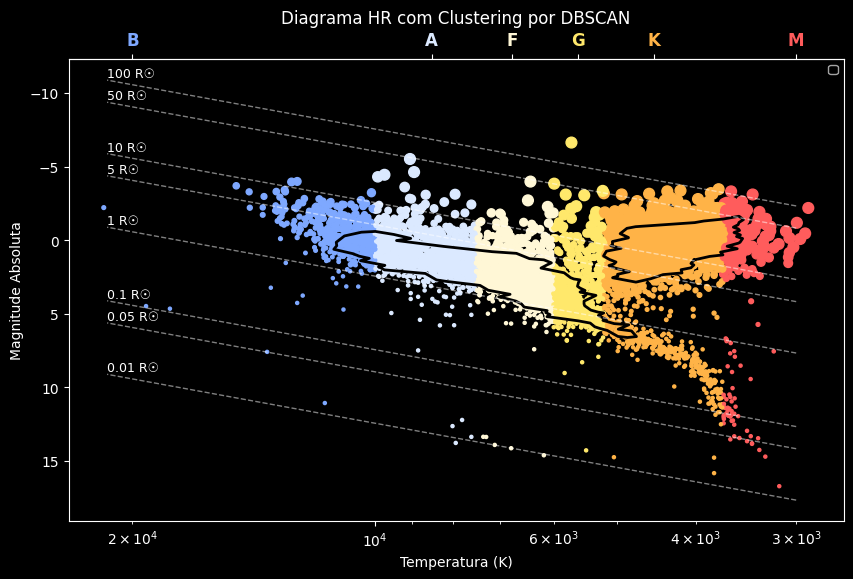

In [47]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

for cl in sorted(dfp["dbscan"].unique()):
    if cl == -1:
        continue

    subset = dfp[dfp["dbscan"] == cl]

    if len(subset) > 600:
        subset = subset.sample(600, random_state=0)

    x = np.log10(subset[col_temp].values)
    y = subset[col_mag].values

    pontos = list(zip(x, y))

    alpha = 1.0
    shape = alphashape.alphashape(pontos, alpha)

    if isinstance(shape, Polygon):
        xs, ys = shape.exterior.xy
        ax.plot(10**np.array(xs), ys, color="black", linewidth=2)

    elif isinstance(shape, MultiPolygon):
        for geom in shape.geoms:
            xs, ys = geom.exterior.xy
            ax.plot(10**np.array(xs), ys, color="black", linewidth=2)

T_sun = 5777
M_sun = 4.83

# intervalo de temperatura do seu gráfico
T_vals = np.logspace(np.log10(3000), np.log10(21500), 500)

raios = [0.01, 0.05, 0.1, 1, 5, 10, 50, 100]

for R in raios:
    M_vals = (
        M_sun
        - 5*np.log10(R)
        - 10*np.log10(T_vals / T_sun)
    )

    ax.plot(T_vals, M_vals, linestyle="--", linewidth=1, color="white", alpha=0.5)

    # rótulo perto da borda direita
    ax.text(
        T_vals[-1],
        M_vals[-1],
        f"{R} R☉",
        fontsize=9,
        verticalalignment='bottom'
    )

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

## Classes Espectrais

### Sem Raios

C:\Users\Marcelo\AppData\Local\Temp\ipykernel_17220\4033277768.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


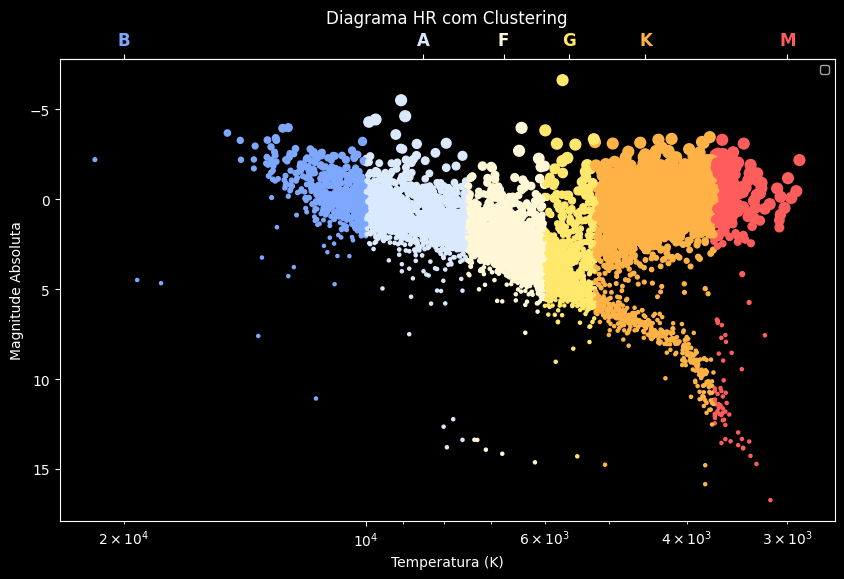

In [48]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR com Clustering")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

### Retas com Raios

C:\Users\Marcelo\AppData\Local\Temp\ipykernel_17220\576562271.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


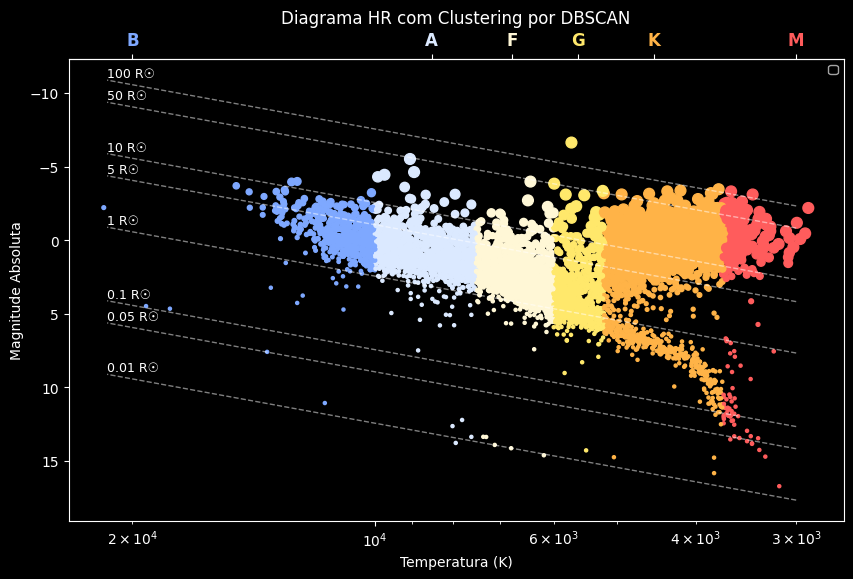

In [49]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

T_sun = 5777
M_sun = 4.83

# intervalo de temperatura do seu gráfico
T_vals = np.logspace(np.log10(3000), np.log10(21500), 500)

raios = [0.01, 0.05, 0.1, 1, 5, 10, 50, 100]

for R in raios:
    M_vals = (
        M_sun
        - 5*np.log10(R)
        - 10*np.log10(T_vals / T_sun)
    )

    ax.plot(T_vals, M_vals, linestyle="--", linewidth=1, color="white", alpha=0.5)

    # rótulo perto da borda direita
    ax.text(
        T_vals[-1],
        M_vals[-1],
        f"{R} R☉",
        fontsize=9,
        verticalalignment='bottom'
    )

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR com Clustering por DBSCAN")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()